![ewatercycle logo](https://raw.githubusercontent.com/eWaterCycle/ewatercycle/main/docs/examples/logo.png)

# PCRGlobWB example use case

This example shows how the [PCRGlobWB model](https://globalhydrology.nl/research/models/pcr-globwb-2-0/) can be used within the eWaterCycle system. It is assumed you have already seen [this tutorial notebook](../../example_model_run_HBV.ipynb) explaining how to run the simple HBV model for the River Leven at Newby Bridge. 

The PCRGlobWB model is an example of a distributed model where fluxes and stores in the balance are calculated for grid cells (often also called pixels). This requires both the forcing data as well as any parameters to also be spatially distributed. Depending on the complexity of the model, these datasets can be quite large in memory size.

Here we will be running PCRGLobWB for Great Brittain and will extract discharge data at the location of the River Leven again, to compare with the HBV model run. We will also demonstrate how to interact with the state of the model, during runtime, showcasing the benefit of using the BMI interface when building experiments using models.

In [1]:
# This cell is only used to suppress some distracting output messages
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import matplotlib.pyplot as plt
from cartopy import crs
from cartopy import feature as cfeature
import fiona
import shapely.geometry
from pyproj import Geod
from rich import print
import pandas as pd
import xarray as xr

import ewatercycle.forcing
import ewatercycle.models
import ewatercycle.parameter_sets

In [3]:
station_latitude = 30 #Newby Bridge location from Google Maps
station_longitude = -113 

## Loading a parameter set

For this example we have prepared and hosted a global parameter set made by Utrecht University. For each model run, what needs to be specified to deliniate the region of interest is a "clone map". The config file has many options, one of which is the location of this clone map.

Note that this is very specific to PCRGlobWB. For complex (and legacy) models like PCRGlobWB one needs to know quite detailed information about the model before being able to run it. However, using eWaterCycle does reduce the time for seting up the model and getting it to run.

In [4]:
parameter_set = ewatercycle.parameter_sets.ParameterSet(
    name="custom_parameter_set",
    directory="/data/shared/parameter-sets/pcrglobwb_global",
    config="./pcrglobwb_sonoran_ERA5_05min.ini",
    target_model="pcrglobwb",
    supported_model_versions={"setters"},
)

In [5]:
print(parameter_set)

ParameterSet(
    name='custom_parameter_set',
    directory=PosixPath('/data/shared/parameter-sets/pcrglobwb_global'),
    config=PosixPath('pcrglobwb_sonoran_ERA5_05min.ini'),
    doi='N/A',
    target_model='pcrglobwb',
    supported_model_versions={'setters'},
    downloader=None
)

## Load forcing data

For this example case, the forcing is generated in [this seperate notebook](generate_forcing.ipynb). This is a common practice when generating forcing takes considerable (CPU, memory, disk) resources. 

In the cell below, we load the pre-generated forcing. Note that in contrast with HBV, PCRGlobWB only needs temperature and precipitation as forcing inputs. HBV also needs potential evaporation. PCRGlobWB calculated potential and actual evaporation as part of its update step.

In [6]:
forcing = ewatercycle.forcing.sources["PCRGlobWBForcing"].load(
    directory="/home/rhut/forcing/sonoran_desert/work/diagnostic/script",
)
print(forcing)

PCRGlobWBForcing(
    start_time='1997-08-01T00:00:00Z',
    end_time='2000-08-31T00:00:00Z',
    directory=PosixPath('/home/rhut/forcing/sonoran_desert/work/diagnostic/script'),
    shape=PosixPath('/home/rhut/forcing/sonoran_desert/work/diagnostic/script/hysets_09488650.shp'),
    filenames={},
    precipitationNC='pcrglobwb_OBS6_ERA-Interim_reanaly_1_day_pr_1997-2000_hysets_09488650.nc',
    temperatureNC='pcrglobwb_OBS6_ERA-Interim_reanaly_1_day_tas_1997-2000_hysets_09488650.nc'
)

## Setting up the model

Note that the model version and the parameterset versions should be compatible.

In [7]:
pcrglob = ewatercycle.models.PCRGlobWB(
    parameter_set=parameter_set,
    forcing=forcing
)
print(pcrglob)

PCRGlobWB(
    parameter_set=ParameterSet(
        name='custom_parameter_set',
        directory=PosixPath('/data/shared/parameter-sets/pcrglobwb_global'),
        config=PosixPath('pcrglobwb_sonoran_ERA5_05min.ini'),
        doi='N/A',
        target_model='pcrglobwb',
        supported_model_versions={'setters'},
        downloader=None
    ),
    forcing=PCRGlobWBForcing(
        start_time='1997-08-01T00:00:00Z',
        end_time='2000-08-31T00:00:00Z',
        directory=PosixPath('/home/rhut/forcing/sonoran_desert/work/diagnostic/script'),
        shape=PosixPath('/home/rhut/forcing/sonoran_desert/work/diagnostic/script/hysets_09488650.shp'),
        filenames={},
        precipitationNC='pcrglobwb_OBS6_ERA-Interim_reanaly_1_day_pr_1997-2000_hysets_09488650.nc',
        temperatureNC='pcrglobwb_OBS6_ERA-Interim_reanaly_1_day_tas_1997-2000_hysets_09488650.nc'
    )
)

In [8]:
pcrglob.version

'setters'

eWaterCycle exposes a selected set of configurable parameters. These can be modified in the `setup()` method.

In [9]:
print(pcrglob.parameters)

dict_items([('start_time', '1997-08-01T00:00:00Z'), ('end_time', '1997-08-01T00:00:00Z'), ('routing_method', 
'accuTravelTime'), ('max_spinups_in_years', '0')])

Calling `setup()` will start up the model container. Be careful with calling it multiple times!

In [10]:
cfg_file, cfg_dir = pcrglob.setup(
    end_time="1997-08-31T00:00:00Z",
    max_spinups_in_years=0
)
cfg_file, cfg_dir

('/home/rhut/repo/projects/book/thesis_projects/BSc/2024_Q2_ElineMol_CEG/rolf_files/pcrglobwb_20241218_120106/pcrglobwb_ewatercycle.ini',
 '/home/rhut/repo/projects/book/thesis_projects/BSc/2024_Q2_ElineMol_CEG/rolf_files/pcrglobwb_20241218_120106')

In [11]:
print(pcrglob.parameters)

dict_items([('start_time', '1997-08-01T00:00:00Z'), ('end_time', '1997-08-31T00:00:00Z'), ('routing_method', 
'accuTravelTime'), ('max_spinups_in_years', '0')])

Note that the parameters have been changed. A new config file which incorporates these updated parameters has been generated as well. If you want to see or modify any additional model settings, you can acces this file directly. When you're ready, pass the path to the config file to `initialize()`.

In [12]:
pcrglob.initialize(cfg_file)

We prepare a small dataframe where we can store the discharge output from the model

In [13]:
time = pd.date_range(pcrglob.start_time_as_isostr, pcrglob.end_time_as_isostr)
timeseries = pd.DataFrame(
    index=pd.Index(time, name="time"), columns=["PCRGlobWB: Leven"]
)
timeseries.head()

,PCRGlobWB: Leven
time,
1997-08-01 00:00:00+00:00,NaN
1997-08-02 00:00:00+00:00,NaN
1997-08-03 00:00:00+00:00,NaN
1997-08-04 00:00:00+00:00,NaN
1997-08-05 00:00:00+00:00,NaN


## Running the model

Simply running the model from start to end is straightforward. At each time step we can retrieve information from the model.

In [14]:
while pcrglob.time < pcrglob.end_time:
    pcrglob.update()

    # Track discharge at station location
    discharge_at_station = pcrglob.get_value_at_coords(
        "discharge", lat=[station_latitude], lon=[station_longitude]
    )
    time = pcrglob.time_as_isostr
    timeseries["PCRGlobWB: Leven"][time] = discharge_at_station[0]

    # Show progress
    print(time,end='\r')  # "\r" clears the output before printing the next timestamp


1997-08-01T00:00:00Z

1997-08-02T00:00:00Z

1997-08-03T00:00:00Z

1997-08-04T00:00:00Z

1997-08-05T00:00:00Z

1997-08-06T00:00:00Z

1997-08-07T00:00:00Z

1997-08-08T00:00:00Z

1997-08-09T00:00:00Z

1997-08-10T00:00:00Z

1997-08-11T00:00:00Z

1997-08-12T00:00:00Z

1997-08-13T00:00:00Z

1997-08-14T00:00:00Z

1997-08-15T00:00:00Z

1997-08-16T00:00:00Z

1997-08-17T00:00:00Z

1997-08-18T00:00:00Z

1997-08-19T00:00:00Z

1997-08-20T00:00:00Z

1997-08-21T00:00:00Z

1997-08-22T00:00:00Z

1997-08-23T00:00:00Z

1997-08-24T00:00:00Z

1997-08-25T00:00:00Z

1997-08-26T00:00:00Z

1997-08-27T00:00:00Z

1997-08-28T00:00:00Z

1997-08-29T00:00:00Z

1997-08-30T00:00:00Z

1997-08-31T00:00:00Z

## Interacting with the model

PCRGlobWB exposes many variables. Just a few of them are shown here:

In [15]:
list(pcrglob.output_var_names)[-15:-5]

['upper_soil_transpiration',
 'snow_water_equivalent',
 'total_runoff',
 'transpiration_from_irrigation',
 'fraction_of_surface_water',
 'bottom_elevation_of_uppermost_layer',
 'industry_water_withdrawal',
 'relativeGroundwaterHead',
 'total_fraction_water_allocation',
 'groundwater_volume_estimate']

Model fields can be fetched as xarray objects (or as flat numpy arrays using `get_value()`):

In [16]:
da = pcrglob.get_value_as_xarray("discharge")
da.thin(5)  # only show every 5th value in each dim

<xarray.DataArray (longitude: 22, latitude: 15)> Size: 3kB
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 3.30474228e-03, 0.00000000e+00,
        1.33315969e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.06944458e-03, 2.45437235e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.58101849e-03, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.83016159e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.66666665e-04,
        2.89351854e-04, 6.46990724e-03, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
...
       [0.00000000e+00, 2.47025460e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        9.52777569e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.00200605e-01, 4.42870378e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 4.40388732e-02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.73611130e-04, 1.90807432e-01,
        1.07048608e-01, 0.00000000e+00, 5.59487334e-03, 3.88897562e+00,
        5.39351860e-03, 1.25234199e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.29745375e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.04921442e-02, 0.00000000e+00, 0.00000000e+00,
        1.17824078e-02, 6.06481498e-03, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.54868050e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.98694002e-02,
        3.11111119e-02, 1.15092349e+00, 1.64580834e+00, 0.00000000e+00,
        0.00000000e+00, 5.87384254e-02, 1.62268523e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.11342604e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.62476853e-01, 0.00000000e+00,
        1.47106480e-02, 0.00000000e+00, 0.00000000e+00]])
Coordinates:
  * latitude   (latitude) float64 120B -116.0 -115.5 -115.1 ... -110.5 -110.1
  * longitude  (longitude) float64 176B 25.04 25.46 25.88 ... 32.96 33.38 33.79

Xarray makes it very easy to plot the data. In the figure below, we add a cross at the location where we collected the discharge every timestep: Leven at Newby bridge.

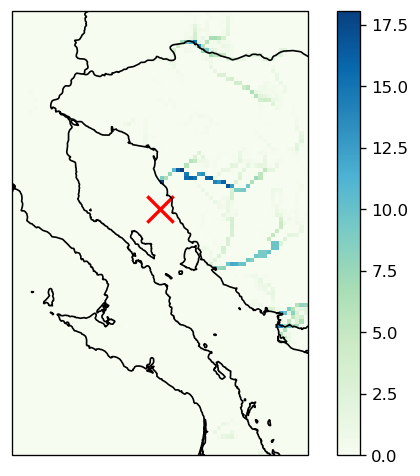

In [17]:
fig = plt.figure(dpi=120)
ax = fig.add_subplot(111, projection=crs.PlateCarree())
da.plot(ax=ax, cmap="GnBu")

# Overlay ocean and coastines
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.RIVERS, color="k")
ax.coastlines()

# Add a red cross marker at the location of the Leven River at Newby Bridge
ax.scatter(station_longitude, station_latitude, s=250, c="r", marker="x", lw=2)

We can get (or set) the values at custom points as well:

<Axes: xlabel='time'>

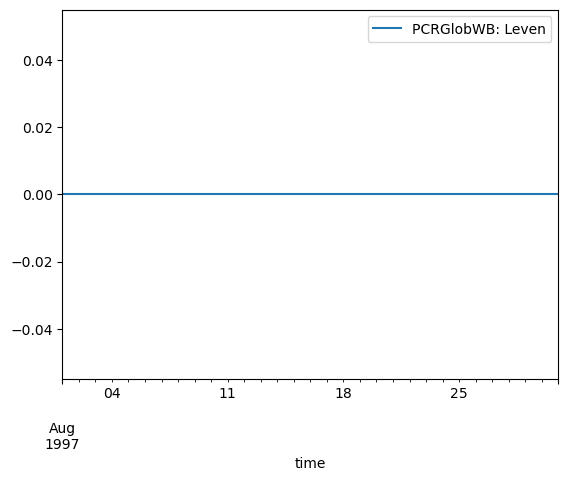

In [18]:
#extra
timeseries.plot()

We of course want to compare this both to observations as well as to the result of the HBV model.


In [19]:
prepared_forcing_path_caravan_central = "/home/rhut/forcing/caravan/camelsgb_73010"
caravan_forcing = ewatercycle.forcing.sources['CaravanForcing'].load(directory="/home/rhut/forcing/caravan/hysets_09488650")
xr_caravan_forcing = xr.open_dataset(caravan_forcing['Q'])


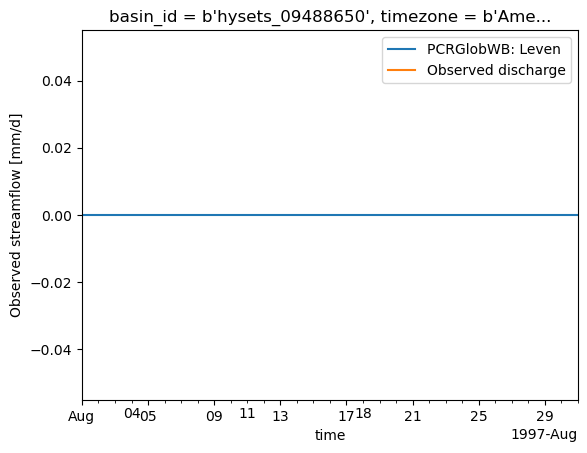

In [20]:
timeseries.plot()
xr_caravan_forcing["Q"].plot(label="Observed discharge")

plt.legend()

## Cleaning up

Models usually perform some "wrap up tasks" at the end of a model run, such as writing the last outputs to disk and releasing memory. In the case of eWaterCycle, another important teardown task is destroying the container in which the model was running. This can free up a lot of resources on your system. Therefore it is good practice to always call `finalize()` when you're done with an experiment.

In [21]:
pcrglob.finalize()